In [1]:
!pip install powerlaw==1.4.6

In [1]:
from scipy.optimize import curve_fit
from sklearn import preprocessing
import networkx as nx
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
import itertools
import collections
import powerlaw
from nltk import bigrams
from nltk.util import ngrams
import os
import glob
import plotly.express as px
import plotly.graph_objs as go
from nltk.corpus import stopwords
import string
# use glob to get all the csv files in the folder



In [2]:
#Upload the file.csv for tweets

df = pd.read_csv('df_tutti_1.csv')
df.shape

(53581, 30)

In [3]:
df.drop(df.columns.difference(['date','renderedContent']), axis=1, inplace=True)
df.shape

In [37]:
df=df.drop_duplicates('renderedContent', keep='first')
df.shape

(53581, 3)

In [40]:
#Text cleaning

import string
punctuation=string.punctuation.replace('+', '')
def remove_punct(text):
    text  = "".join([char for char in text if char not in punctuation])
    text = re.sub('[0-9]', '', text)
    return text

df['Tweet_punct'] = df['renderedContent'].apply(lambda x: remove_punct(x) )
df['Tweet_punct']

0        SonoJuro bizzarripaolo giuno MovStelle Ha chiu...
1        MichaelPioggia La Francia non ha nessun motivo...
2        SonoJuro bizzarripaolo giuno MovStelle Premett...
3        AndreaRomano pdnetwork PiuEuropa Tra mpo saran...
4        ViVilaVitaOra Non una ma  volte siiiiiiiii la ...
                               ...                        
53576    tg  A linea notte sta venendo fuori la ipocris...
53577    PRIMA PAGINA IL MATTINO  MeloniSalvini prove d...
53578    agnesepini “Più che plausibile che Salvini par...
53579    La trincea di Salvini E Giorgetti avverte io p...
53580    No ma credo che nel caso sarebbe lo stesso Mat...
Name: Tweet_punct, Length: 53581, dtype: object

In [15]:
#Split all the words in a tweet and save them

words_in_tweet = [tweet.lower().split() for tweet in df['Tweet_punct']]

In [34]:
# Further text cleaning from stopwords

stop_words = set(stopwords.words('italian'))

tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

#create a unique list from all tweets, and set to dataframe (words)

word= [item for sublist in tweets_nsw for item in sublist]
words=pd.DataFrame()
words['word']=word
words['count'] = df.apply(lambda _: '', axis=1)
tweets_nsw

[['sonojuro',
  'bizzarripaolo',
  'giuno',
  'movstelle',
  'chiuso',
  'rubinetti',
  'gas',
  'tutta',
  'leuropa',
  'cosa',
  'dovuto',
  'fare',
  'ricordiamoci',
  'pure',
  'fin',
  'ucraina',
  'donbas',
  'stati',
  'uccisi',
  'migliaia',
  'oppositori',
  'truppe',
  'nazifasciste',
  'ucraine',
  'nessuno',
  'parla',
  'armi',
  'risolve',
  'pace'],
 ['michaelpioggia',
  'francia',
  'nessun',
  'motivo',
  'fare',
  'parcheggi',
  'italia',
  'russia',
  'là',
  'te',
  'sembra',
  'normale',
  'comportamento',
  'delleuropa',
  'questione'],
 ['sonojuro',
  'bizzarripaolo',
  'giuno',
  'movstelle',
  'premetto',
  'difendo',
  'putin',
  'detesto',
  'scatenato',
  'guerra',
  'fratricida',
  'ucraini',
  'russi',
  'condanna',
  'certami',
  'chiedo',
  'tutta',
  'leuropa',
  'schiera',
  'lucraina',
  'giustocon',
  'lintenzione',
  'impoverirla',
  'mentre',
  'russia',
  'putin',
  'ritorsione',
  'cosa',
  'fatto'],
 ['andrearomano', 'pdnetwork', 'piueuropa', 'm

In [47]:
word

AttributeError: 'list' object has no attribute 'type'

In [45]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

#Remove word with len<val in the list with all words

def remove_values_from_list(the_list, val):
    return [value for value in the_list if len(value)>=val]

y=remove_values_from_list(word, 4)
len(y)


747118

In [36]:
# Count the word in the list with all words in tweets in order to make a ranking and save it

frequ=FreqDist(y)
rank=pd.DataFrame(frequ.items(), columns=['Word', 'Count'])
rank=rank.set_index('Word')
rank.sort_values(by=['Count'])
rank.to_csv('words_ranking.csv')

In [11]:
#Remove word with len<val_low len>val_upp  in the list of list, the words divided by tweets 

def remove_values_from_listoflist(the_list, val_low, val_upp):
    for i in range(0,len(the_list)):
        r=[value for value in the_list[i] if ((len(value)<val_low)or(len(value)>val_upp))]
        for j in range(0, len(r)):
            the_list[i].remove(r[j])
    return the_list
x=remove_values_from_listoflist(tweets_nsw, 4, 20)

In [20]:
#Remove word with len<val in the list of list, the words divided by tweets 

def remove_values_from_listoflist(the_list, val1):
    for i in range(0,len(the_list)):
        r=[value for value in the_list[i] if (rank.loc[value]['Count']<val1)]
        for j in range(0, len(r)):
            the_list[i].remove(r[j])
    return the_list


In [21]:
#Use one of the two methods above

x=remove_values_from_listoflist(tweets_nsw, 4)

In [22]:
#Create the combinations between the words in each tweets

from itertools import combinations
for i in range(0,len(x)):
    if i==0:
        comb=list(combinations(x[i], 2))
    else:
        comb[len(comb):]=list(combinations(x[i], 2))


In [23]:
# Create counter of words in clean bigrams, choose the number of most_common

bigram_counts = collections.Counter(comb)
bigram_df = pd.DataFrame(bigram_counts.most_common(500000),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts

d = bigram_df.set_index('bigram').T.to_dict('records')
d[0].items()
len(d[0])

500000

In [27]:
# Create network plot
G = nx.Graph()

# Create connections between nodes using ranking as threshold
for k, v in d[0].items():
    if((4<rank.loc[k[0]]['Count'])&(4<rank.loc[k[1]]['Count'])):
        G.add_edge(k[0], k[1], weight=(1/v))

(G.number_of_nodes(),G.number_of_edges())

(15102, 410229)

In [28]:
G.remove_edges_from(nx.selfloop_edges(G))
(G.number_of_nodes(),G.number_of_edges(),nx.density(G))

(15102, 408537, 0.003582788879865639)

C:\Users\emanu\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


(2.65052363308963, 0.06605066761863451)

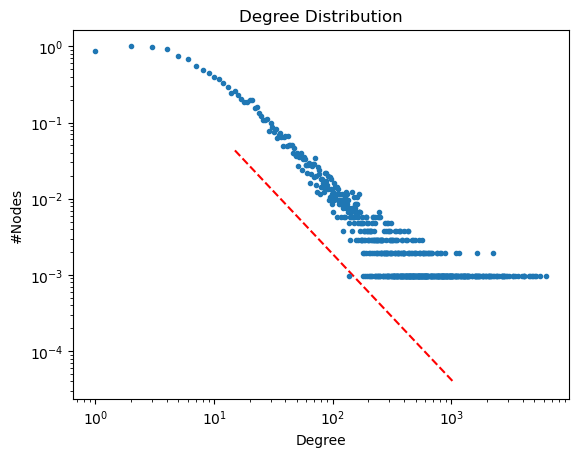

In [31]:
#Hist for degree distribution
hist = nx.degree_histogram(G)

#fit with a power-law NB: you can set a max_degree and min_degree
fit = powerlaw.Fit(np.array(hist)+1,xmin=15, xmax=10000, discrete=True)
fit.power_law.plot_pdf(color='r',linestyle='--',label='fit pdf')

#reshape hist to use the MinMaxScaler and standardize the data
histr=np.reshape(hist, (1,-1)).T
scaler = preprocessing.MinMaxScaler()
y=scaler.fit_transform(histr)

#plot the degree distribution
plt.plot(range(0, len(hist)), y,'.')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
# plt.ylim(-1,500)
# plt.xlim(0,1)
plt.loglog()
# plt.show()
#Take the x**(-alpha) from the fit parameter
alpha=fit.power_law.alpha+1
sigma=fit.power_law.sigma
(alpha,sigma)

C:\Users\emanu\AppData\Local\Temp\ipykernel_4772\718644843.py:15: RuntimeWarning: divide by zero encountered in log
  y = np.log(hist)


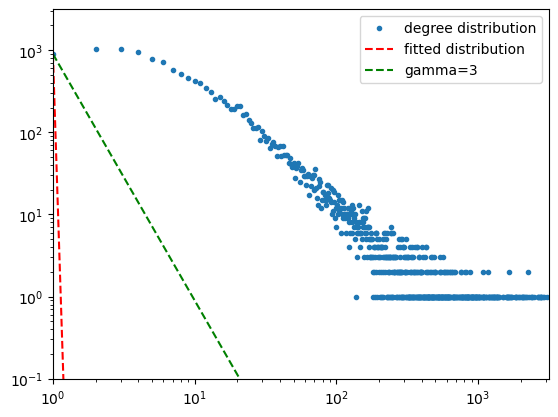

Gamma=53.56413601373915


In [30]:
k = nx.degree_histogram(G)
sig=np.array(k[1:])


# define the function to fit
def expfunc(x, a , b):
    return a*pow(x,-b)

# bin the degree distribution
bins = np.arange(len(k))
hist = nx.degree_histogram(G)

# fit the logarithm of the degree distribution to a linear function
x = bins[1:]
y = np.log(hist)

popt, pcov = curve_fit(expfunc, x, k[1:], sigma=(sig/1)+2, absolute_sigma=True)

# plot the degree distribution and the fitted distribution on a logarithmic scale
plt.plot(range(0, len(hist)), hist,'.',label='degree distribution')
plt.plot(x, expfunc(x, *popt), 'r--', label='fitted distribution')
plt.plot(x, expfunc(x, popt[0], 3.0), 'g--', label='gamma=3')
plt.legend()
plt.ylim( (10**-1,10**3.5) )
plt.xlim( (10**0,10**3.5) )
plt.xscale('log')
plt.yscale('log')
plt.show()

# print the estimated value of b
print(f"Gamma={popt[1]}")

In [32]:
nx.write_edgelist(G, "word_dict.edgelist")